## Conditional EVAE ON FER2013 v2 CNN structure

1. unconditional v.s. conditional

2. Try out different loss fun, such as MSE VS. mae; MAE works better 

#### 1. Unconditional generation 




In [1]:
import numpy as np
from keras.utils import to_categorical
import pandas as pd

df = pd.read_csv('/Users/lb/projects/emo_dataset/data/fer2013/fer2013.csv')
df = df.values
tem = df[:, 1]

pixels = np.zeros((df.shape[0], 48 * 48))

for ix in range(pixels.shape[0]):
    t = tem[ix].split(' ')
    for iy in range(pixels.shape[1]):
        pixels[ix, iy] = int(t[iy])

y = df[:, 0]

split = int(0.9* pixels.shape[0])

X_train = pixels[:split]
y_train = y[:split]

X_test  = pixels[split:]
y_test  = y[split:]

X_train= np.asarray(X_train)
X_test = np.asarray(X_test)
X_train = X_train/ 255.
X_test  = X_test/ 255.

org_dim = 48*48
image_size = X_train.shape[1]

X_train = np.reshape(X_train, [-1, org_dim])
X_test = np.reshape(X_test, [-1, org_dim])


/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
import os

In [3]:
img_rows, img_cols = 48, 48

if K.image_data_format() == 'channels_first':
    X_train= X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    
    epsilon = K.random_normal(shape = (batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [5]:
input_shape = (48, 48, 1)
batch_size = 100
kernel_size = 3
filters = 32
latent_dim = 2

x = Input(shape=input_shape,)

In [6]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D, AveragePooling2D


In [7]:
# z_b #using more complex structure in terms of encoder
x_1 = x

for i in range(4):
    filters *= 2
    x_1 = Conv2D(filters=64,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x_1)

# shape info needed to build decoder model
shape = K.int_shape(x_1)

x_1 = MaxPooling2D( pool_size = 2, strides= 2, padding='same')(x_1)

## z_b
# generate latent vector Q(z|X)
x_1 = Flatten()(x_1)
x_1 = BatchNormalization()(x_1)
x_1 = Dense(1200, activation='relu')(x_1)
x_1 = BatchNormalization()(x_1)
x_1 = Dense(600, activation ='relu')(x_1)
x_1 = BatchNormalization()(x_1)
x_1 = Dense(300, activation ='relu')(x_1)
x_1 = BatchNormalization()(x_1)
x_1 = Dense(64, activation = 'relu')(x_1)
z_mean_1 = Dense(latent_dim, name = 'z_mean_1')(x_1)
z_log_var_1 = Dense(latent_dim,name = 'z_log_var_1' )(x_1)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z_1 = Lambda(sampling, output_shape=(latent_dim,), name='z_1')([z_mean_1, z_log_var_1])

In [8]:
## z_s

x_2 = x

for i in range(3):
    filters *= 2
    x_2 = Conv2D(filters=32,
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')(x_2)

# shape info needed to build decoder model
shape = K.int_shape(x_2)


## z_b
# generate latent vector Q(z|X)
x_2 = Flatten()(x_2)
x_2 = BatchNormalization()(x_2)
x_2 = Dense(200, activation='relu')(x_2)
x_2 = BatchNormalization()(x_2)
x_2 = Dense(100, activation='relu')(x_2)
z_mean_2 = Dense(latent_dim,name = 'z_mean_2')(x_2)
z_log_var_2 = Dense(latent_dim, name='z_log_var_2')(x_2)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z_2 = Lambda(sampling, output_shape=(latent_dim,), name='z_2')([z_mean_2, z_log_var_2])

In [9]:
encoder_1 = Model(x, [z_mean_1, z_log_var_1, z_1], name ='base_encoder')
encoder_2 = Model(x, [z_mean_2, z_log_var_2, z_2], name = 's_encoder')

In [10]:
encoder_1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 24, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 12, 12, 64)   36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 6, 6, 64)     36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [11]:
latent_inputs_1 = Input(shape=(latent_dim,), name='z_sampling_1')
x_1 = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs_1)
x_1 = Reshape((shape[1], shape[2], shape[3]))(x_1)

for i in range(3):
    x_1 = Conv2DTranspose(filters = 64,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x_1)
    filters //= 2
x_1 = BatchNormalization()(x_1)
outputs_1 = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          )(x_1)

# instantiate decoder model
decoder_1 = Model(latent_inputs_1, outputs_1, name='decoder_1')
x_decoded_mean_1 =  decoder_1(encoder_1(x)[2])

In [12]:
latent_inputs_2 = Input(shape=(latent_dim,), name='z_sampling_2')
x_2 = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs_2)
x_2 = Reshape((shape[1], shape[2], shape[3]))(x_2)

for i in range(3):
    x_2 = Conv2DTranspose(filters = 32,
                        kernel_size=2,
                        activation='relu',
                        strides=2,
                        padding='same')(x_2)
    filters //= 2
x_2 = BatchNormalization()(x_2)
outputs_2 = Conv2DTranspose(filters=1,
                          kernel_size=3,
                          activation='sigmoid',
                          padding='same',
                          )(x_2)

# instantiate decoder model
decoder_2 = Model(latent_inputs_2, outputs_2, name = 'decoder_2')
x_decoded_mean_2 = decoder_2(encoder_2(x)[2])

In [13]:
decoder_1.summary()
decoder_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling_1 (InputLayer)    (None, 2)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 1152)              3456      
_________________________________________________________________
reshape_1 (Reshape)          (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 24, 24, 64)        36928     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_7 (Batch (None, 48, 48, 64)        256       
__________

In [14]:
## loss functions
a_1 = 0


from keras.layers import Input, Dense, Lambda, Layer
from keras.losses import MAE as mae

class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean_1, x_decoded_mean_2):
        x = K.flatten(x)
        x_decoded_mean_1_squash = K.flatten(x_decoded_mean_1)
        x_decoded_mean_2_squash = K.flatten(x_decoded_mean_2)
        xent_loss_1 = 48*48 * metrics.mse(x, x_decoded_mean_1_squash) 
        xent_loss_2 = 48*48 * metrics.mse(x, x_decoded_mean_2_squash)
        kl_loss_1 = - 0.5 * K.sum(1 + z_log_var_1 - K.square(z_mean_1) 
                                  - K.exp(z_log_var_1), axis=-1)
        kl_loss_2  = - 0.5 * K.sum(1 + z_log_var_2 - K.square(z_mean_2) 
                                  - K.exp(z_log_var_2), axis=-1)
        vse_pen_1  =  - 0.5 * K.sum(1+ z_log_var_1 - K.square(z_mean_2)- K.exp(z_log_var_2), axis=-1)
        vse_pen_2  =  - 0.5 * 1 * K.sum(((z_log_var_1) - K.exp(z_log_var_2)),axis = -1)
        vse_pen_enc  =  K.sum(K.exp(-K.square(z_1 - z_2)), axis = -1)
                        
        vse_pen_dec =   K.exp(-K.square(xent_loss_1 - xent_loss_2))
        return K.mean(xent_loss_1 + kl_loss_1 + xent_loss_2 + kl_loss_2 + a_1*(vse_pen_dec - vse_pen_enc)) 
    
        #return K.mean(vse_pen)
# restrict alpha value of [0,1]; referrable [0 - 0.25]
    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean_1 = inputs[1]
        x_decoded_mean_2 = inputs[2]
        loss = self.vae_loss(x, x_decoded_mean_1, x_decoded_mean_2)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

In [15]:
from keras.models import Model
from keras import metrics
from keras.callbacks import EarlyStopping,TensorBoard,History, ReduceLROnPlateau
from keras.optimizers import Adamax

history = History()
early = EarlyStopping(monitor='val_loss', patience=15)
model_callbacks = [history, early]
y = CustomVariationalLayer()([x, x_decoded_mean_1, x_decoded_mean_2])
evae_fer2013_unconditional = Model(x, y)
evae_fer2013_unconditional.compile(optimizer=Adamax(), loss=None)

In [16]:
evae_fer2013_unconditional.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
base_encoder (Model)            [(None, 2), (None, 2 1349672     input_1[0][0]                    
__________________________________________________________________________________________________
s_encoder (Model)               [(None, 2), (None, 2 275328      input_1[0][0]                    
__________________________________________________________________________________________________
decoder_1 (Model)               (None, 48, 48, 1)    96641       base_encoder[1][2]               
__________________________________________________________________________________________________
decoder_2 

In [17]:
evae_fer2013_unconditional.fit(X_train,
        epochs=150,
        verbose=2,
        batch_size=batch_size,
        callbacks = model_callbacks,
        validation_data=(X_test, None)) 

Train on 32298 samples, validate on 3589 samples
Epoch 1/150
 - 582s - loss: 199.8247 - val_loss: 218.0168
Epoch 2/150
 - 569s - loss: 181.6940 - val_loss: 196.1983
Epoch 3/150
 - 567s - loss: 178.5323 - val_loss: 201.2446
Epoch 4/150
 - 566s - loss: 176.7319 - val_loss: 192.2072
Epoch 5/150
 - 565s - loss: 176.0973 - val_loss: 196.6416
Epoch 6/150
 - 565s - loss: 175.2663 - val_loss: 183.0102
Epoch 7/150
 - 566s - loss: 174.6724 - val_loss: 205.1399
Epoch 8/150
 - 568s - loss: 174.4150 - val_loss: 249.3127
Epoch 9/150
 - 565s - loss: 173.9421 - val_loss: 186.6448
Epoch 10/150
 - 567s - loss: 173.6562 - val_loss: 198.2132
Epoch 11/150
 - 564s - loss: 173.1360 - val_loss: 195.3375
Epoch 12/150
 - 561s - loss: 172.6536 - val_loss: 179.6354
Epoch 13/150
 - 568s - loss: 172.3707 - val_loss: 177.5715
Epoch 14/150
 - 563s - loss: 172.5621 - val_loss: 190.3882
Epoch 15/150
 - 560s - loss: 172.5556 - val_loss: 191.7917
Epoch 16/150
 - 606s - loss: 171.8320 - val_loss: 181.9140
Epoch 17/150
 - 

(-0.5, 383.5, 383.5, -0.5)

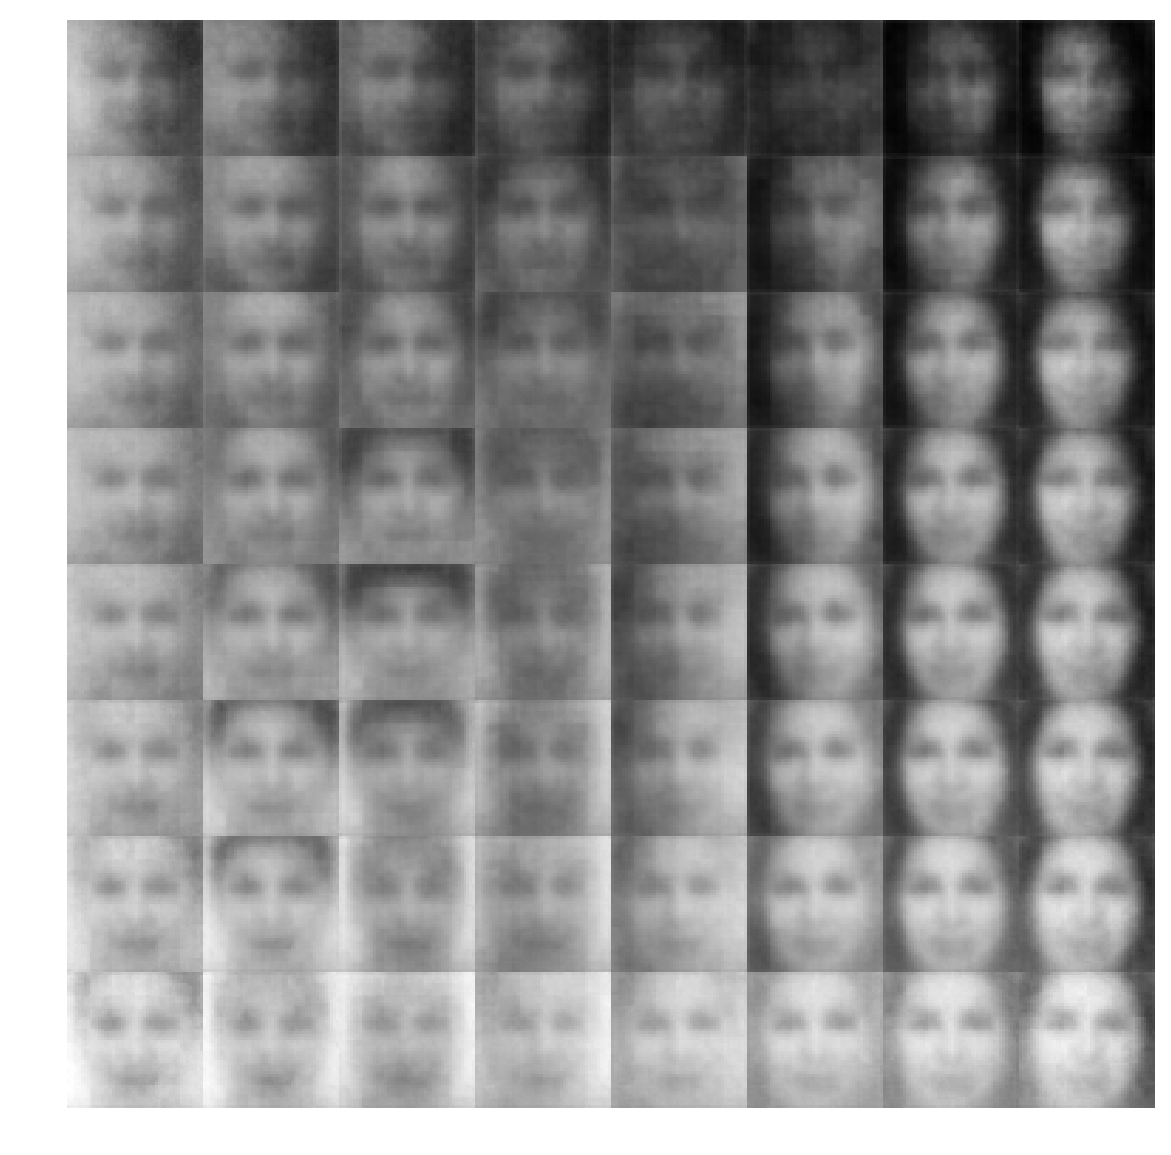

In [19]:
## Unconditional generation 


%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
from scipy.stats import norm

n = 8  # num of face per row and per column
figure = np.zeros((48 * n, 48 * n)) #figure size 
# divide x and y cooridnate into 10 even splits, 0.1, 0.2... 
# then feed this inverse cdf function of a normal distribution to get latent variable (gridx, gridy)
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
#grid_z = norm.ppf(np.linspace(0.05, 0.95, n))
#grid_t = norm.ppf(np.linspace(0.05, 0.95, n))
#grid_d = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):    
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder_1.predict(z_sample)
        fig = x_decoded[0].reshape(48, 48)
        figure[i * 48: (i + 1) * 48,
               j * 48: (j + 1) * 48] = fig
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap ='gray')  #gray scale the figure
plt.axis('off')

In [20]:
## conditinal on X_TRAIN 

encoded_images = encoder_1.predict(X_train, batch_size= batch_size)
decoded_images = decoder_1.predict(encoded_images[2], batch_size= batch_size)

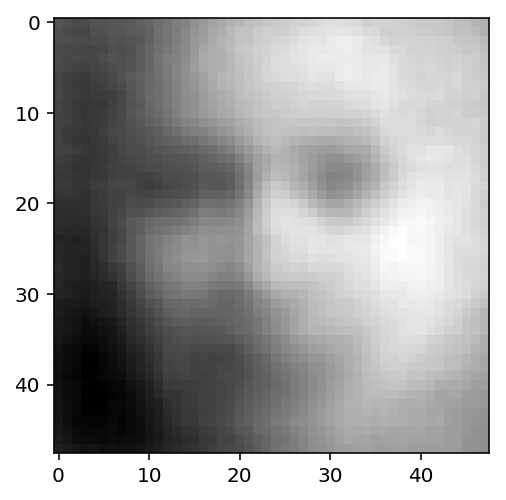

In [21]:
plt.imshow(decoded_images[10].reshape((48,48)), cmap ='gray')

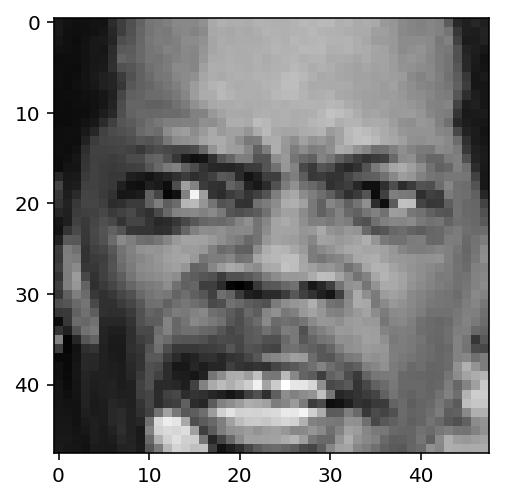

In [46]:
plt.imshow(X_train[10].reshape((48,48)), cmap = 'gray')

In [47]:
## Saving the X_train generated faces

#np.save('evae_fer2013_unconditional_X_train_e1d1_a=0_mae_v2', decoded_images)


#### Conditional EVAE on Fer2013 with Adam optimiser 

In [1]:
### Tryout the normalised value between 0 and 1 for rather than mu as 0 and std as 1


import numpy as np
from keras.utils import to_categorical
import pandas as pd

df = pd.read_csv('/Users/lb/projects/emo_dataset/data/fer2013/fer2013.csv')
df = df.values
tem = df[:, 1]

pixels = np.zeros((df.shape[0], 48 * 48))

for ix in range(pixels.shape[0]):
    t = tem[ix].split(' ')
    for iy in range(pixels.shape[1]):
        pixels[ix, iy] = int(t[iy])

y = df[:, 0]

split = int(0.9* pixels.shape[0])

X_train = pixels[:split]
y_train = y[:split]

X_test  = pixels[split:]
y_test  = y[split:]

X_train= np.asarray(X_train)
X_test = np.asarray(X_test)
X_train = X_train/ 255.
X_test  = X_test/ 255.

org_dim = 48*48
image_size = X_train.shape[1]

X_train = np.reshape(X_train, [-1, org_dim])
X_test = np.reshape(X_test, [-1, org_dim])


/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

In [7]:
from keras import backend as K
img_rows, img_cols = 48, 48

if K.image_data_format() == 'channels_first':
    X_train= X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [8]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    
    epsilon = K.random_normal(shape = (batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [13]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.layers import BatchNormalization
from keras.layers.merge import concatenate as concat
from keras.layers import PReLU, MaxPooling2D

input_shape = (48, 48, 1)
batch_size = 100
kernel_size = 3
filters = 32
latent_dim = 2
label_shape = (7, )


x = Input(shape=input_shape,)
n_Y = Y_train.shape[1]
labels = Input(shape=(n_Y,))
y_labels = Dense(48*48)(labels)
y_labels = Reshape((48, 48, 1))(y_labels)
inputs = concat([x, y_labels])

In [14]:
## trying out the batchnormal 

x_1 = x

for i in range(4):
    filters *= 2
    x_1 = Conv2D(filters=128,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x_1)

# shape info needed to build decoder model
shape = K.int_shape(x_1)

x_1 = MaxPooling2D( pool_size = 2, strides= 2, padding='same')(x_1)

## z_b
# generate latent vector Q(z|X)
x_1 = Flatten()(x_1)
x_1 = BatchNormalization()(x_1)
x_1 = Dense(1200)(x_1)
x_1 = PReLU()(x_1)
x_1 = BatchNormalization()(x_1)
x_1 = Dense(600)(x_1)
x_1 = PReLU()(x_1)
x_1 = BatchNormalization()(x_1)
x_1 = Dense(300)(x_1)
x_1 = PReLU()(x_1)
x_1 = BatchNormalization()(x_1)
x_1 = Dense(64, activation = 'relu')(x_1)
z_mean_1 = Dense(latent_dim, name = 'z_mean_1')(x_1)
z_log_var_1 = Dense(latent_dim,name = 'z_log_var_1' )(x_1)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z_1 = Lambda(sampling, output_shape=(latent_dim,), name='z_1')([z_mean_1, z_log_var_1])

In [15]:

## z_s

x_2 = x

for i in range(3):
    filters *= 2
    x_2 = Conv2D(filters=64,
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')(x_2)

# shape info needed to build decoder model
shape = K.int_shape(x_2)


## z_b
# generate latent vector Q(z|X)
x_2 = Flatten()(x_2)
x_2 = BatchNormalization()(x_2)
x_2 = Dense(200, activation='relu')(x_2)
x_2 = BatchNormalization()(x_2)
x_2 = Dense(100, activation='relu')(x_2)
z_mean_2 = Dense(latent_dim,name = 'z_mean_2')(x_2)
z_log_var_2 = Dense(latent_dim, name='z_log_var_2')(x_2)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z_2 = Lambda(sampling, output_shape=(latent_dim,), name='z_2')([z_mean_2, z_log_var_2])

In [16]:
encoder_1 = Model([x, labels], [z_mean_1, z_log_var_1, z_1], name = 'encoder_1')
encoder_2 = Model([x, labels], [z_mean_2, z_log_var_2, z_2], name = 'encoder_2')

In [17]:
encoder_1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 24, 24, 128)  1280        input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 12, 12, 128)  147584      conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 6, 6, 128)    147584      conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_12 

In [18]:
latent_inputs_1 = Input(shape=(latent_dim,), name='z_sampling_1')
x_1 = concat([latent_inputs_1, labels])
x_1 = Dense(2056)(x_1)
x_1 = PReLU()(x_1)
x_1 = Dense(shape[1] * shape[2] * shape[3])(x_1)
x_1 = PReLU()(x_1)
x_1 = Reshape((shape[1], shape[2], shape[3]))(x_1)

for i in range(3):
    x_1 = Conv2DTranspose(filters=512,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x_1)
    filters //= 2

outputs_1 = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          )(x_1)

# instantiate decoder model
decoder_1 = Model([latent_inputs_1,labels], outputs_1, name ='decoder_1')
x_decoded_mean_1 =  decoder_1([encoder_1([x,labels])[2], labels])

In [19]:
latent_inputs_2 = Input(shape=(latent_dim,), name='z_sampling_2')
x_2 = concat([latent_inputs_2, labels])
x_2 = Dense(shape[1] * shape[2] * shape[3], activation='relu')(x_2)
x_2 = Reshape((shape[1], shape[2], shape[3]))(x_2)

for i in range(3):
    x_2 = Conv2DTranspose(filters=128,
                        kernel_size=3,
                        activation='relu',
                        strides=2,
                        padding='same')(x_2)
    filters //= 2

outputs_2 = Conv2DTranspose(filters=1,
                          kernel_size=3,
                          activation='sigmoid',
                          padding='same',
                          )(x_2)

# instantiate decoder model
decoder_2 = Model([latent_inputs_2, labels], outputs_2, name = 'decoder_2')
x_decoded_mean_2 = decoder_2([encoder_2([x,labels])[2], labels])

In [20]:
decoder_1.summary()
decoder_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z_sampling_1 (InputLayer)       (None, 2)            0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 7)            0                                            
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 9)            0           z_sampling_1[0][0]               
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 2056)         20560       concatenate_5[0][0]              
__________

In [21]:
## loss functions
a_1 = 0


from keras.layers import Input, Dense, Lambda, Layer
from keras.losses import MAE as mae
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean_1, x_decoded_mean_2):
        x = K.flatten(x)
        x_decoded_mean_1_squash = K.flatten(x_decoded_mean_1)
        x_decoded_mean_2_squash = K.flatten(x_decoded_mean_2)
        xent_loss_1 = 48*48 * metrics.mae(x, x_decoded_mean_1_squash) 
        xent_loss_2 = 48*48 * metrics.mae(x, x_decoded_mean_2_squash)
        kl_loss_1 = - 0.5 * K.sum(1 + z_log_var_1 - K.square(z_mean_1) 
                                  - K.exp(z_log_var_1), axis=-1)
        kl_loss_2  = - 0.5 * K.sum(1 + z_log_var_2 - K.square(z_mean_2) 
                                  - K.exp(z_log_var_2), axis=-1)
        vse_pen_1  =  - 0.5 * K.sum(1+ z_log_var_1 - K.square(z_mean_2)- K.exp(z_log_var_2), axis=-1)
        vse_pen_2  =  - 0.5 * 1 * K.sum(((z_log_var_1) - K.exp(z_log_var_2)),axis = -1)
        vse_pen_enc  =  K.sum(K.exp(-K.square(z_1 - z_2)), axis = -1)
                        
        vse_pen_dec =   K.exp(-K.square(xent_loss_1 - xent_loss_2))
        return K.mean(xent_loss_1 + kl_loss_1 + xent_loss_2 + kl_loss_2 + a_1*(vse_pen_dec - vse_pen_enc)) 
    
        #return K.mean(vse_pen)
# restrict alpha value of [0,1]; referrable [0 - 0.25]
    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean_1 = inputs[1]
        x_decoded_mean_2 = inputs[2]
        loss = self.vae_loss(x, x_decoded_mean_1, x_decoded_mean_2)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

In [22]:
from keras.models import Model
from keras import metrics
from keras.callbacks import EarlyStopping,TensorBoard,History, ReduceLROnPlateau

history = History()
early = EarlyStopping(monitor='val_loss', patience=20)
model_callbacks = [history, early]
y = CustomVariationalLayer()([x, x_decoded_mean_1,x_decoded_mean_2])
evae_fer2013_cond = Model([x,labels], y)
evae_fer2013_cond.compile(optimizer='adam', loss=None)

In [23]:
evae_fer2013_cond.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 7)            0                                            
__________________________________________________________________________________________________
encoder_1 (Model)               [(None, 2), (None, 2 1992604     input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
encoder_2 (Model)               [(None, 2), (None, 2 566016      input_7[0][0]                    
          

In [24]:
evae_fer2013_cond.fit([X_train, Y_train],
        shuffle = True, 
        epochs=150,
        verbose=2,
        batch_size=batch_size,
        callbacks = model_callbacks,
        validation_data=([X_test,Y_test], None)) 

Train on 32298 samples, validate on 3589 samples
Epoch 1/150
 - 4928s - loss: 805.7618 - val_loss: 1333.1470
Epoch 2/150
 - 4867s - loss: 721.7106 - val_loss: 1086.2795
Epoch 3/150
 - 4924s - loss: 694.8208 - val_loss: 931.5749
Epoch 4/150
 - 5138s - loss: 685.4791 - val_loss: 758.5284
Epoch 5/150
 - 5162s - loss: 681.0930 - val_loss: 747.0451
Epoch 6/150
 - 5036s - loss: 680.6427 - val_loss: 803.8571
Epoch 7/150
 - 5243s - loss: 678.3923 - val_loss: 723.3044
Epoch 8/150
 - 6530s - loss: 676.8602 - val_loss: 703.5926
Epoch 9/150
 - 4883s - loss: 675.4226 - val_loss: 762.8904
Epoch 10/150
 - 4889s - loss: 674.5519 - val_loss: 707.3875
Epoch 11/150
 - 4882s - loss: 672.3981 - val_loss: 868.7879
Epoch 12/150
 - 4887s - loss: 671.7439 - val_loss: nan
Epoch 13/150
 - 4877s - loss: 673.4048 - val_loss: 670.1851
Epoch 14/150
 - 7513s - loss: 670.6691 - val_loss: 737.8370
Epoch 15/150
 - 5154s - loss: 668.9253 - val_loss: 683.1793
Epoch 16/150
 - 4980s - loss: 671.0056 - val_loss: 388329444181

KeyboardInterrupt: 

In [ ]:
### 

In [25]:
def construct_numvec(emo, z= None):
    out = np.zeros((1, n_Y))
    out[:, emo] = 1.
    if z is None:
        return(out)
    
    else:
        for i in range((len(z))):
            out[:, i] = z[i]
        return (out)
    
    

In [26]:
sample_emo = construct_numvec(6)

print sample_emo

[[0. 0. 0. 0. 0. 0. 1.]]


In [27]:
print Y_train.shape[0]

32298


In [28]:
sample_neutral = np.array([[sample_emo],]*32298)

In [29]:
sample_neutral = sample_neutral[:, 0, 0, :]

In [30]:
print sample_neutral[2]

[0. 0. 0. 0. 0. 0. 1.]


In [34]:
## lower elbo compare to the unconditional ones
### conditional generation

encoded_images = encoder_1.predict([X_train, sample_neutral], batch_size= batch_size)
decoded_images = decoder_1.predict([encoded_images[2], sample_neutral], batch_size= batch_size)

In [35]:
encoded_images_ = np.asarray(encoded_images)



In [47]:
#np.save('Z_Fer2013_neutral_X_train_V1', encoded_images_)

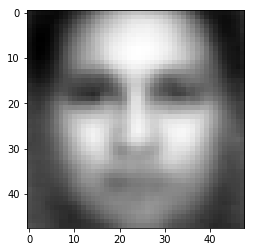

In [43]:
% matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(decoded_images[15].reshape((48,48)), cmap ='gray')


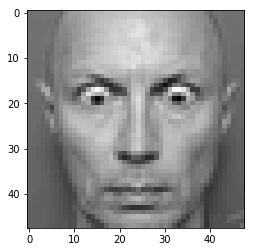

In [42]:
plt.imshow(X_train[15].reshape((48,48)), cmap = 'gray')

In [44]:
## saving the conditinal ones on the X_train; Y_train 
## saving the conditional ones on the sample_neutral; sample_neutral

#np.save('evae_conditional_fer2013_sample_neutral_sample_neutral_a=0_mae_v2_brokenTraining', decoded_images)

In [73]:
z_latent_embedding, _, _  = encoder_1.predict([X_train, Y], batch_size= batch_size)

(-5.650680328868195, 4.59993531849222, -5.873700750023237, 6.676403176933638)

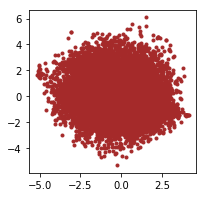

In [74]:
### to see the latnet embeddings

plt.figure(figsize=(3,3))
plt.scatter(z_latent_embedding[:, 0], z_latent_embedding[:,1], color = 'brown', marker = '.')
#plt.colorbar()
plt.axis('on')



In [100]:
### encoding the training dataset

z_mean, z_var, z_latent_1 = encoder_1.predict([X_train, Y_train], batch_size = batch_size)

In [101]:
print Y_train.shape

(32181, 7)


In [102]:
dec_emo = decoder_1.predict([z_mean,sample_emo_])

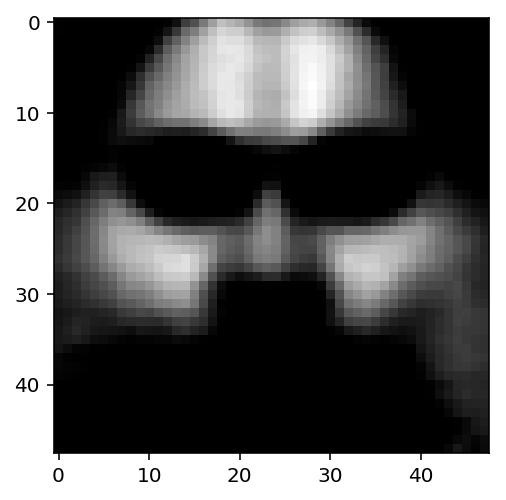

In [103]:
plt.imshow(dec_emo[10].reshape((48,48)), cmap = 'gray' )

In [73]:
print dec_emo[1].max()

0.3358959


In [105]:
### compute the ssim

from scipy import spatial
X_train_ = X_train.reshape(X_train.shape[0], -1)
dec_emo_ = dec_emo.reshape(dec_emo.shape[0], -1)
result = 1 - spatial.distance.cosine(X_train_[11].astype('float32'), dec_emo_[11])
print result

0.4622833728790283


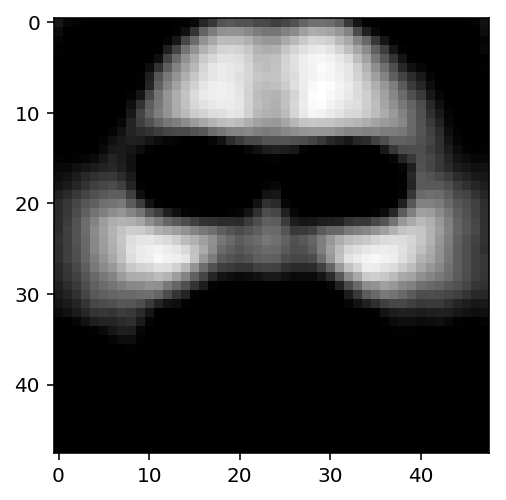

In [39]:
plt.imshow(dec_emo[14].reshape((48,48)), cmap = 'gray')

(-0.5, 383.5, 383.5, -0.5)

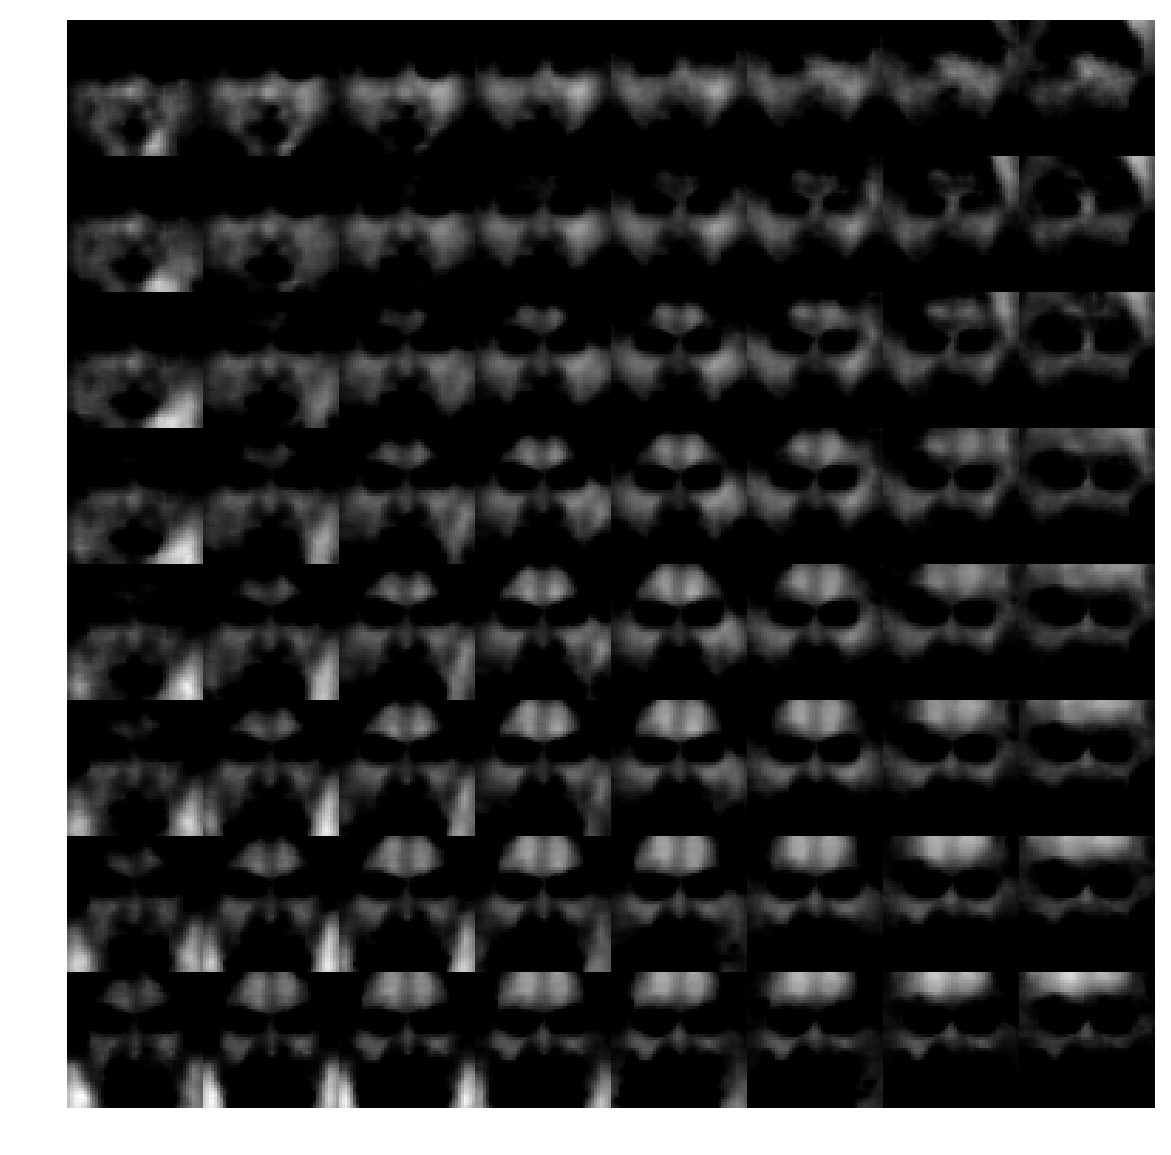

In [30]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
from scipy.stats import norm

n = 8  # num of face per row and per column
figure = np.zeros((48 * n, 48 * n)) #figure size 
# divide x and y cooridnate into 10 even splits, 0.1, 0.2... 
# then feed this inverse cdf function of a normal distribution to get latent variable (gridx, gridy)
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
#grid_z = norm.ppf(np.linspace(0.05, 0.95, n))
#grid_t = norm.ppf(np.linspace(0.05, 0.95, n))
#grid_d = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):    
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder_1.predict([z_sample, sample_emo])
        fig = x_decoded[0].reshape(48, 48)
        figure[i * 48: (i + 1) * 48,
               j * 48: (j + 1) * 48] = fig
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap ='gray')  #gray scale the figure
plt.axis('off')